In [17]:
import glob
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from torchvision.transforms import Compose, ToTensor, Resize, Normalize, RandomHorizontalFlip, ToPILImage
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
import torchvision.models as models
import random
import os
import albumentations as A

## 파라미터 설정

In [3]:
'''
device = "cuda" if torch.cuda.is_available() else "cpu"
device
'''

'\ndevice = "cuda" if torch.cuda.is_available() else "cpu"\ndevice\n'

In [5]:
# 맥 mps 설정
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")
print(f"현재 디바이스는 {device} 입니다.")

현재 디바이스는 mps:0 입니다.


In [39]:
CFG = {
    'IMG_SIZE':512,
    'EPOCHS':5,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':5,
    'SEED':41,
    'train_magnification':20,
    'test_magnification':20,
}

In [7]:
pth_name=f"./git_ignore/pthfile/{CFG['train_magnification']}X_e{CFG['EPOCHS']}.pth"
train_data_path = f"./git_ignore/PDA_mask_img/{CFG['train_magnification']}X/**/*.png"
test_data_path = f"./git_ignore/PDA_mask_img/{CFG['test_magnification']}X/**/*.png"
print(f"pth_name:{pth_name}")
print(f"train_data_path:{train_data_path}")
print(f"test_data_path:{test_data_path}")

pth_name:./git_ignore/pthfile/20X_e30.pth
train_data_path:./git_ignore/PDA_mask_img/20X/**/*.png
test_data_path:./git_ignore/PDA_mask_img/20X/**/*.png


In [8]:
# 시드 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## 데이터 경로지정

In [9]:
train_path_list = sorted(glob.glob(train_data_path))
train_path_list[:10]

['./git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=10425,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=10425,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=10878,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=10878,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=11785,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=11785,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=12238,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=12238,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=12691,w=518,h=518]-labelled.png',
 './git_ignore/PDA_

In [10]:
test_path_list = sorted(glob.glob(test_data_path))
test_path_list[:10]

['./git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=10425,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=10425,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=10878,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=10878,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=11785,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=11785,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=12238,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=12238,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=12691,w=518,h=518]-labelled.png',
 './git_ignore/PDA_

In [11]:
# train data path
train_mask_path = train_path_list[0::2]
train_img_path = train_path_list[1::2]
train_mask_path[:10]

['./git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=10425,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=10878,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=11785,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=12238,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=12691,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=13144,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=13598,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=14051,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=14504,w=518,h=518

In [12]:
train_img_path[:10]

['./git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=10425,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=10878,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=11785,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=12238,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=12691,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=13144,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=13598,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=14051,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=14504,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.0

In [13]:
# test data path
test_mask_path = test_path_list[0::2]
test_img_path = test_path_list[1::2]
test_mask_path[:10]

['./git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=10425,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=10878,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=11785,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=12238,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=12691,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=13144,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=13598,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=14051,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=14504,w=518,h=518

In [14]:
test_img_path[:10]

['./git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=10425,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=10878,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=11785,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=12238,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=12691,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=13144,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=13598,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=14051,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=14504,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.0

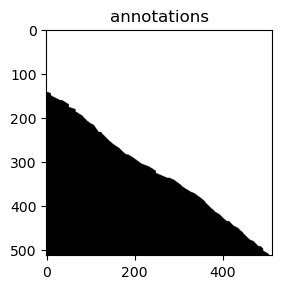

In [15]:
annotation = Image.open(train_mask_path[0])
plt.subplot(1,2,1)
plt.title("annotations")
plt.imshow(annotation)

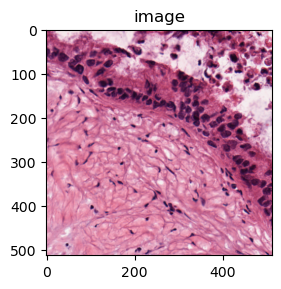

In [16]:
image = Image.open(train_img_path[0])
plt.subplot(1,2,2)
plt.title("image")
plt.imshow(image)


## Class 정의

In [18]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, img_path, mask_path, train = True, transform = None):
        self.images = img_path
        self.annotations = mask_path
        
        # 학습용 or 평가용
        self.X_train = self.images[:int(0.8 * len(self.images))]
        self.X_test = self.images[int(0.8 * len(self.images)):]

        self.Y_train = self.annotations[:int(0.8 * len(self.annotations))]
        self.Y_test = self.annotations[int(0.8 * len(self.annotations)):]

        self.train = train
        self.transform = transform


    def __len__(self):
        if self.train:
            return len(self.X_train) # 학습용 데이터셋 길이
        else:
            return len(self.X_test) # 평가용 데이터셋 길이
        
    
    def __getitem__(self, i):
        if self.train:  # 학습용 데이터
            X_train = Image.open(self.X_train[i])
            Y_train = Image.open(self.Y_train[i])
            transformed = self.transform(image = X_train, masks = Y_train)
            X_train = transformed["image"]
            Y_train = transformed["masks"]
            return X_train, Y_train
        
        else:  # 평가용 데이터
            X_test = Image.open(self.X_test[i])
            Y_test = Image.open(self.Y_test[i])
            transformed = self.transform(image = X_test, masks = Y_test)
            X_test = transformed["image"]
            Y_test = transformed["masks"]
            return X_test, Y_test

In [19]:
# U-Net 모델 정의
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Transfer the ResNet model for encoding
        self.resnet = models.resnet50(pretrained=True)
        
        self.encoder1 = nn.Sequential(self.resnet.conv1, self.resnet.bn1, self.resnet.relu, self.resnet.maxpool) #64
        self.encoder2 = self.resnet.layer1  # 256
        self.encoder3 = self.resnet.layer2  # 512
        self.encoder4 = self.resnet.layer3  # 1024
        self.encoder5 = self.resnet.layer4  # 2048
        
        self.upsample4 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride = 2)
        self.dec4_1 = nn.Conv2d(2048, 1024, kernel_size=3, padding = 1)
        self.dec4_2 = nn.Conv2d(1024, 512, kernel_size=3, padding = 1)

        self.upsample3 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride = 2)
        self.dec3_1 = nn.Conv2d(1024, 512, kernel_size = 3, padding = 1)
        self.dec3_2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)

        self.upsample2 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride = 2)
        self.dec2_1 = nn.Conv2d(512, 256, kernel_size = 3, padding = 1)
        self.dec2_2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)

        self.upsample1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride = 2)
        self.dec1_1 = nn.Conv2d(128, 64, kernel_size = 3, padding = 1)
        self.dec1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dec1_3 = nn.Conv2d(64, 1, kernel_size=1)

        # 합성곱과 업샘플링층의 활성화 함수
        self.relu = nn.ReLU()

    def forward(self, x):
        # Encoding
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)
        x5 = self.encoder5(x4)
        
        # Decoding
        x = self.upsample4(x5)
        x = torch.cat([x, x4], dim=1)
        x = self.dec4_1(x)
        x = self.relu(x)
        x = self.dec4_2(x)
        x = self.relu(x)

        x = self.upsample3(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec3_1(x)
        x = self.relu(x)
        x = self.dec3_2(x)
        x = self.relu(x)

        x = self.upsample2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec2_1(x)
        x = self.relu(x)
        x = self.dec2_2(x)
        x = self.relu(x)

        x = self.upsample1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec1_1(x)
        x = self.relu(x)
        x = self.dec1_2(x)
        x = self.relu(x)
        x = self.dec1_3(x)

        x = torch.squeeze(x)
        
        return x

## 데이터 불러오기

In [23]:
transform = A.Compose([
    A.Resize(height = CFG['IMG_SIZE'], width = CFG['IMG_SIZE']),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
    A.HorizontalFlip(p=0.5),
])

In [26]:
# 학습용 데이터
train_set = CustomDataset(img_path = train_img_path,
                          mask_path = train_mask_path,
                          transform = transform)
# 평가용 데이터
test_set = CustomDataset(img_path = test_img_path,
                         mask_path=test_mask_path,
                         transform = transform,
                         train=False)

In [36]:
train_loader = DataLoader(train_set, batch_size = CFG["BATCH_SIZE"], shuffle = True)
test_loader = DataLoader(test_set)

In [37]:
print(len(train_set),len(test_set))

752 189


In [38]:
print(len(train_loader),len(test_loader))

151 189


## 학습

In [40]:
model = UNet().to(device)

optimizer = Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

/Users/moksu/miniforge3/envs/lion/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/moksu/miniforge3/envs/lion/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/moksu/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [01:03<00:00, 1.60MB/s]


In [40]:
for epoch in range(CFG["EPOCHS"]):

    for data, label in tqdm(train_loader):
        optimizer.zero_grad()
        preds = model(data.to(device))
        
        label = torch.squeeze(label)
        loss = nn.BCEWithLogitsLoss()(preds, label.type(torch.FloatTensor).to(device))
        loss.backward()
        optimizer.step()
    print(f"epoch{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(), pth_name)

  0%|          | 0/703 [00:00<?, ?it/s]

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 256 but got size 128 for tensor number 1 in the list.

## 결과 저장

In [23]:
# output_path 설정
epochs = CFG["EPOCHS"]
output_name = f"{train_magnification}_{test_magnification}_{epochs}"
output_path = f"git_ignore/output/output({output_name})"
output_path

'git_ignore/output(20X_20X_30)'

KeyboardInterrupt: 

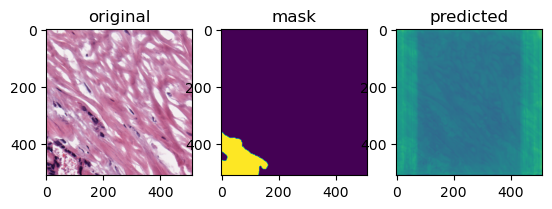

In [24]:
# output_save
os.mkdir(output_path)
for i in range(len(test_loader)):
    model.load_state_dict(torch.load(CFG["pth_name"], map_location=device))
    data, label = test_set[i]
    pred = model(torch.unsqueeze(data, dim=0).to(device))
    pred = pred.to("cpu")
    label = torch.squeeze(label)
    with torch.no_grad():
        plt.subplot(1,3,1)
        plt.title("original")
        plt.imshow(ToPILImage()(data))
        plt.subplot(1,3,2)
        plt.title("mask")
        plt.imshow(label)
        plt.subplot(1,3,3)
        plt.title("predicted")
        plt.imshow(pred)
        plt.savefig(f'{output_path}/{output_name}_{i+1}.png')